In [1]:
!pip install numpy pandas matplotlib opencv-python scikit-image

You should consider upgrading via the 'c:\users\kedar\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import time
import random
import cv2
import os
import math
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.widgets import Cursor
from PIL import Image
import hashlib
from yolo_opencv import detect_object
import pandas as pd

%matplotlib inline

#confuse and diffuse scheme
#date : 2019.6.3 10.56

# def PL_PWLCM(y0,p2,exp32):
#     y1=0
#     if y0<p2:
#         y1 = math.floor(exp32*y0/p2)
#     elif p2<y0 and y0 < exp32/2:
#         y1 = math.floor(exp32*(y0-p2)/(exp32/2 - p2))
#     elif y0 == exp32/2 :
#         y1 = 0
#     else:
#         y1 = PL_PWLCM(exp32-y0, p2, exp32)
#     return y1


def SkewTent(y0,p2,exp32):
    y1=0
    if y0<p2:
        y1 = math.floor(exp32*y0/p2)
    elif y0 == p2 :
        y1 = exp32-1
    elif p2<y0 and y0 < exp32:
        y1 = math.floor(exp32*(exp32-y0)/(exp32 - p2))
    return y1

'''
PWLCM MAP
'''
def SCCS_MAP(y0, p2, exp32):
    y1=0
    if y0<p2:
        y1 = math.floor(exp32*y0/p2)
    elif p2<y0 and y0 < exp32/2:
        y1 = math.floor(exp32*(y0-p2)/(exp32/2 - p2))
    elif y0 == exp32/2 :
        y1 = 0
    else:
        y1 = SCCS_MAP(exp32-y0, p2, exp32)
    return y1

'''
Logistic Map used in CML Map
'''
def PL_Logistic(x0,exp32):
    x1 = math.floor(4*x0*(exp32-x0)/exp32)
    return x1

'''
CML MAP
'''
def CCCS_MAP(x0,exp32, ep=0.5):
    x0 = x0 % 256
    log_x1 = PL_Logistic(x0, exp32)
    x1 = (1-ep) * log_x1 + (ep/2) * log_x1 + log_x1
    return math.floor(x1)

def PL_PWLCM_Logistic(x0,y0,p1,z0,p2):
    exp32 = 4294967296
    y1 = SCCS_MAP(y0,p1,exp32)
    x1 = SkewTent(z0,p2,exp32)
    z1 = CCCS_MAP(x0,exp32)
    temp1 = x1 ^ y1
    r1 = (temp1 + z1) % exp32
    return x1,y1,z1,r1

def PWLCM_Init(x0,y0,p1,p2,exp32,n):
    x1 = x0
    y1 = y0
    for i in range(n):
        x1 = SCCS_MAP(x1,p1,exp32)
        y1 = SCCS_MAP(y1,p2,exp32)
    return x1,y1

def Logistic_Init(x0,n,exp32):
    x1 = x0
    for i in range(n):
        x1 = CCCS_MAP(x1,exp32)
    return x1

def InitPRNG(x0,y0,p1,z0,p2,n):
    exp32 = 4294967296
    for i in range(n):
        y1,z1 = PWLCM_Init(y0,z0,p1,p2,exp32,n)
        x1 = SCCS_MAP(x0,n,exp32)
    return x1,y1,z1

# get the second column
def takeSecond(elem):
    return elem[1]
#key generation v2 output : PRNGlist, 32-Bit sorted sorting index 
def getPRNG(a,b,c,x0,y0,p1,z0,p2):
    iLen = math.ceil(a*b*c)
    SortLen = (a)*(b)*c # if the a and c are not the interal multiple of 2, discard the last row and column 
    #print('the prng interation rounds is :',iLen)
    #print("the sort list's len is :", SortLen)
    SortList = list();
    ValueList = np.zeros(a*b*c, dtype = int, order = 'C')
    time_start=time.time()
    for iNum in range(iLen):
        #print('total:', iLen, '+++++++Now:',iNum)
        x0,y0,z0,res = PL_PWLCM_Logistic(x0,y0,p1,z0,p2)
        if iNum < SortLen:
            SortList.append([iNum,res])
        if (iNum+1)*4 <= a*b*c:
            ValueList[iNum*4] = (res >> 24) & 0xff
            ValueList[iNum*4+1] = (res >> 16) & 0x00ff
            ValueList[iNum*4+2] = (res >> 8) & 0x0000ff
            ValueList[iNum*4+3] = (res >> 0) & 0x000000ff
        else:
            tail = a * b * c % 4
            shiftUnit = [0xff,0x00ff,0x0000ff,0x000000ff]
            for i in range(tail):
                if iNum * 4 + i < len(ValueList):
                    ValueList[iNum*4+i] = (res >> 24-i*8) & shiftUnit[i]
    time_end=time.time()
    #print('PRNG Generation time cost:',time_end-time_start,'s')
    SortList.sort(key=takeSecond)
    if c == 1: #gray
        return SortList,ValueList.reshape(a,b),x0,y0,z0
    else:
        return SortList,ValueList.reshape(a,b,c),x0,y0,z0

# Initialization
# def getParas(key):
#     p2 = key & 0x7fffffff
#     z0 = (key>>31) & 0x7fffffff
#     p1 = (key>>62) & 0x7fffffff
#     y0 = (key>>93) & 0x7fffffff
#     x0 = (key>>124) & 0xffffffff
    
#     x0,y0,z0 = InitPRNG(x0,y0,p1,z0,p2,20)    
#     return x0,y0,p1,z0,p2

def generate_key(key):
    k1 = hashlib.sha512(key)
    k1 = bin(int.from_bytes(k1.digest(), "big"))[2:494]
    k2 = hashlib.sha512(k1.encode("utf-8"))
    k2 = bin(int.from_bytes(k2.digest(), "big"))[2:494]
    return k2

def getKeys(key):
    k1 = key[:80]
    k2 = key[160:160+80]
    k3 = key[240:240+36]
    k4 = key[276: 276+36]
    k5 = key[312:348]
    k6 = key[348:384]
    k7 = key[384:420]
    k8 = key[420:456]
    k9 = key[456:492]
    k11 = bin(int(k1[:40], 2) ^ int(k2[:40], 2))
    k12 = bin(int(k1[40:], 2) ^ int(k2[40:], 2))
    k13 = bin(int(k3, 2) ^ int(k4, 2))
    k14 = bin(int(k5, 2) ^ int(k6, 2))
    k15 = bin(int(k7, 2) ^ int(k8, 2) ^ int(k9, 2))
    
#     x1 = int(k11, 2) / 2**40
#     x2 = int(k12, 2) / 2**40
#     x3 = int(k13, 2) / 2**35
#     x4 = int(k14, 2) / 2**35
    x5 = int(k15, 2) / 2**35
    x6 = 0.87 + ((int(k13, 2) ^ int(k14, 2)) / 2**35) % 0.13
    x7 = (int(k13, 2) ^ int(k15, 2)) / 2**35
    x8 = 0.87 + ((int(k14, 2) ^ int(k15, 2)) / 2**35) % 0.13
    x9 = (int(k13, 2) ^ int(k14, 2) ^ int(k15, 2)) / 2**35
    
#     x1 = x1 ^ x9
#     x2 = x2 ^ x8
#     x3 = x3 ^ x7
#     x4 = x4 ^ x6
#     x5 = x5 ^ (x6 ^ x7 ^ x8 ^ x9)
       
    
    return list(map(lambda x: x % 1, [x5, x6, x7, x8, x9]))

def getParas(key):
    key = generate_key(key)
    xs = getKeys(key)
    val = 2 ** 32
    x0 = xs[0] * val
    y0 = xs[1] * val
    z0 = xs[2] * val
    p1 = xs[3] * val
    p2 = xs[4] * val
    
    x0,y0,z0 = InitPRNG(x0,y0,p1,z0,p2,20)    
    return x0,y0,p1,z0,p2

# def Enc(a,SortKey,ValueKey,scale,diffRound=1):
#     w,h = a.shape
#     k = SortKey
#     #confusion
#     c =  np.zeros((w,h), dtype=int)
#     c = a.copy()
#     istep = h//2
#     for i in range(len(k)):
#             iRow = (k[i]//istep)*2
#             iCol = (k[i] % istep)*2
#             iRow0 = (i // istep)*2
#             iCol0 = (i % istep)*2
#             c[iRow0,iCol0] = a[iRow,iCol]
#             c[iRow0+1,iCol0] = a[iRow+1,iCol]
#             c[iRow0,iCol0+1] = a[iRow,iCol+1]
#             c[iRow0+1,iCol0+1] = a[iRow+1,iCol+1]

#     #扩散 diffuse
#     b = np.zeros((w,h), dtype=int)
#     b = c.copy()
#     for iwhole in range(diffRound):
#         #step2.1 diffuse row
#         for iRow in range(0,w,1):
#             if iRow == 0:
#                 b[iRow,:] = (b[-1,:] + b[iRow,:] + ValueKey[iRow,:]) % scale
#             else:
#                 b[iRow,:] = (b[iRow-1,:] + b[iRow,:] + ValueKey[iRow,:]) % scale

#         #step2.2 diffuse column
#         for iCol in range(0,h,1):
#             if iCol == 0:
#                 b[:, iCol] = (b[:, -1] + b[:, iCol] + ValueKey[:, iCol]) % scale
#             else:
#                 b[:, iCol] = (b[:, iCol-1] + b[:, iCol] + ValueKey[:, iCol]) % scale


#     return b

# def Dec(a,SortKey,ValueKey,scale,diffRound=1):
#     #step1: de-confusion
#     w,h = a.shape
#     c =  np.zeros((w,h), dtype=int)
#     c = a.copy()
#     k = SortKey
#     for iwhole in range(diffRound):
#         for iCol in range(h-1,-1,-1):
#             if iCol == 0:
#                 c[:, iCol] = (c[:, iCol] - c[:, -1] - ValueKey[:, iCol]) % scale
#             else:
#                 c[:, iCol] = (c[:, iCol] - c[:, iCol-1] - ValueKey[:, iCol]) % scale
#         for iRow in range(w-1,-1,-1):
#             if iRow == 0:
#                 c[iRow,:] = (c[iRow,:] - c[-1,:] - ValueKey[iRow,:])% scale
#             else:
#                 c[iRow,:] = (c[iRow,:] - c[iRow-1,:] - ValueKey[iRow,:])% scale 
    
#     b =  np.zeros((w,h), dtype=int)
#     b = c.copy()
#     istep = h//2
#     #print("step:",istep)
#     for i in range(len(k)):
#             iRow = (k[i]//istep)*2
#             iCol = (k[i] % istep)*2
#             iRow0 = (i // istep)*2
#             iCol0 = (i % istep)*2
#             b[iRow,iCol] = c[iRow0,iCol0]
#             b[iRow+1,iCol] = c[iRow0+1,iCol0]
#             b[iRow,iCol+1] = c[iRow0,iCol0+1]
#             b[iRow+1,iCol+1] = c[iRow0+1,iCol0+1]
    
#     return b

def Enc(a,SortKey,ValueKey,scale,diffRound=1):
    w,h = a.shape
    k = SortKey
    #confusion
    c =  np.zeros((w,h), dtype=int)
    c = a.copy().flatten()
#     print(len(k))
    for i in range(len(k)):
        temp = c[i]
        c[i] = c[k[i]]
        c[k[i]] = temp
        
    b = np.zeros((w,h), dtype=int)
    b = c.copy().reshape((w,h))
    for iwhole in range(diffRound):
        #step2.1 diffuse row
        for iRow in range(0,w,1):
            if iRow == 0:
                b[iRow,:] = (b[-1,:] + b[iRow,:] + ValueKey[iRow,:]) % scale
            else:
                b[iRow,:] = (b[iRow-1,:] + b[iRow,:] + ValueKey[iRow,:]) % scale

        #step2.2 diffuse column
        for iCol in range(0,h,1):
            if iCol == 0:
                b[:, iCol] = (b[:, -1] + b[:, iCol] + ValueKey[:, iCol]) % scale
            else:
                b[:, iCol] = (b[:, iCol-1] + b[:, iCol] + ValueKey[:, iCol]) % scale


    return b

def Dec(a,SortKey,ValueKey,scale,diffRound=1):
    w,h = a.shape
    c =  np.zeros((w,h), dtype=int)
    c = a.copy()
    k = SortKey
    
    for iwhole in range(diffRound):
        for iCol in range(h-1,-1,-1):
            if iCol == 0:
                c[:, iCol] = (c[:, iCol] - c[:, -1] - ValueKey[:, iCol]) % scale
            else:
                c[:, iCol] = (c[:, iCol] - c[:, iCol-1] - ValueKey[:, iCol]) % scale
        for iRow in range(w-1,-1,-1):
            if iRow == 0:
                c[iRow,:] = (c[iRow,:] - c[-1,:] - ValueKey[iRow,:])% scale
            else:
                c[iRow,:] = (c[iRow,:] - c[iRow-1,:] - ValueKey[iRow,:])% scale 
    
    b =  np.zeros((w,h), dtype=int)
    b = c.copy().flatten()
    #confusion
    for i in range(len(k)-1, -1, -1):
        temp = b[i]
        b[i] = b[k[i]]
        b[k[i]] = temp
    return b.reshape((w,h))


def DoEnc(img,k=None, round=2):
    n = round # Encryption round
    w,h = img.shape #return row and column
    keys = []
    for i in range(n):
        x0,y0,p1,z0,p2 = getParas(img)
        keys.append((x0, y0, p1, z0, p2))
#         print("Encryption: ", (x0, y0, p1, z0, p2))
        sort,valuekey,x0,y0,z0 = getPRNG(w,h,1,x0,y0,p1,z0,p2)
        arr = np.array(sort)
        sortkey = arr[:,0]
        img = Enc(img,sortkey,valuekey,256,2)
    return img, keys


def DoDec(img,k,round = 2):
    n = round # Encryption round    
    w,h = img.shape #return row and column
    for i in range(n-1,-1,-1):
        x0,y0,p1,z0,p2 = k[i]
#         print("Decryption: ", (x0, y0, p1, z0, p2))
        sort,valuekey,x0,y0,z0 = getPRNG(w,h,1,x0,y0,p1,z0,p2)
        arr = np.array(sort)
        sortkey = arr[:,0]
        img = Dec(img,sortkey,valuekey,256,2)
    return img

In [3]:
def DoColorEnc(img,k=None, round=2):
    n = round # Encryption round
    #step1. initialization
    
    w,h,d = img.shape #return row and column
    img = img.reshape((w,h*d))
#     print(img.shape)
    keys = list()
    for i in range(n):
        x0,y0,p1,z0,p2 = getParas(np.ascontiguousarray(img))
        if k is not None:
            z0 += 1
        keys.append((x0,y0,p1,z0,p2))
        sort,valuekey,x0,y0,z0 = getPRNG(w,h*d,1,x0,y0,p1,z0,p2)
        arr = np.array(sort)
        sortkey = arr[:,0]
        img = Enc(img,sortkey,valuekey,256,2)
    
    img = img.reshape((w,h,d))
    return img, keys

def DoColorDec(img, k, round=2):
    n = round # Encryption round    
    w,h,d = img.shape #return row and column
    img = img.reshape((w,h*d))
    for i in range(n-1,-1,-1):
        x0,y0,p1,z0,p2 = k[i]
        sort,valuekey,x0,y0,z0 = getPRNG(w,h*d,1,x0,y0,p1,z0,p2)
        arr = np.array(sort)
        sortkey = arr[:,0]
        img = Dec(img,sortkey,valuekey,256,2)
    img = img.reshape((w,h,d))
    return img

def ObjectDetectionTest(file, crop=True, draw=False):
    og = cv2.imread(file)
    og = cv2.cvtColor(og, cv2.COLOR_BGR2RGB)
    
    if crop:
        start_det = time.perf_counter()
        img, (x, y) = detect_object(file,draw=draw)
        end_det = time.perf_counter()
        print("Detection Time:", (end_det - start_det))
        if img.size > 0:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            print(img)
            print("No Object Detected!")
            return
    else:
        img = og

#     img = cv2.imread(file)
    print("Image Size:", og.shape)
    print("Detected Shape", img.shape)

    plt.figure(figsize=(20, 18))
    plt.subplot(1, 3, 1)
    plt.imshow(og, cmap="gray")
    plt.title("Original Image")
    
    if crop:
        plt.subplot(1, 3, 2)
        plt.imshow(img, cmap="gray")
        plt.title("Object Detected")
    
    start_enc = time.perf_counter()
    encrypted, keys = DoColorEnc(img, round=1)
    end_enc = time.perf_counter()
    print("Encryption Time:", (end_enc - start_enc))
    
    start_dec = time.perf_counter()
    decrypted = DoColorDec(img, keys, round=1)
    end_dec = time.perf_counter()
    print("Decryption Time:", (end_dec - start_dec))
    
    if crop:
        og[y:y+encrypted.shape[0], x: x+encrypted.shape[1]] = encrypted
    else:
        og = encrypted
    
    plt.subplot(1, 3, 3)
    plt.imshow(og)
    plt.title("Encrypted")
    plt.show()
    
    if crop:
         return (file, og.shape, (end_enc - start_enc), (end_dec - start_enc), (x, y, img.shape[0], img.shape[1]))
    
    return (file, og.shape, (end_enc - start_enc), (end_dec - start_enc))
    
# ObjectDetectionTest("./new/group.jpg")
# ObjectDetectionTest("./new/group.jpg", crop=False)

def ColorDetectionTest(draw=False, to_file=None):
    path = "./new/"
    arr = []
    for file in os.listdir(path):
        print(path+file)
        _, shape, enctime, dectime, coords = ObjectDetectionTest(path + file, draw=draw)
        _, shape, totalenctime, totaldectime = ObjectDetectionTest(path + file, crop=False)
        arr.append((file, shape, totalenctime, totaldectime, enctime, dectime, coords[0], coords[1], coords[2], coords[3]))
    arr = np.array(arr)
    arr = pd.DataFrame(arr, columns=["File Name", "Image Size", "Total Encryption Time", "Total Decryption Time", "Encryption Time", "Decryption Time", "X", "Y", "Width", "Height"])
    
    print(arr.head())
    if to_file:
        arr.to_csv(to_file, index=False)


# Full Histogram

520.png 's size is : (470, 526, 3)
Red channel's variance is  2703.285456905345
Green channel's variance is  2808.922585557367
Blue channel's variance is  3864.240888179742
Encrypted Red channel's variance is  5456.097247327879
Encrypted Green channel's variance is  5477.940509467498
Encrypted Blue channel's variance is  5474.324351570918
Correlation
R channel: Horizontal             Vertical            Diagonal
0.9921906148055711 0.9886639628494291 0.9824646764794522
G channel: Horizontal             Vertical            Diagonal
0.9931492151792771 0.9879337838815371 0.9826729868313052
B channel: Horizontal             Vertical            Diagonal
0.9957551805574324 0.9899859619818822 0.9873386477410455
Correlation
R channel: Horizontal             Vertical            Diagonal
-0.0174905807012742 -0.002206129526579283 -0.012060461478013868
G channel: Horizontal             Vertical            Diagonal
0.016141763851887984 -0.010133100251921648 0.006070609970055948
B channel: Horizontal

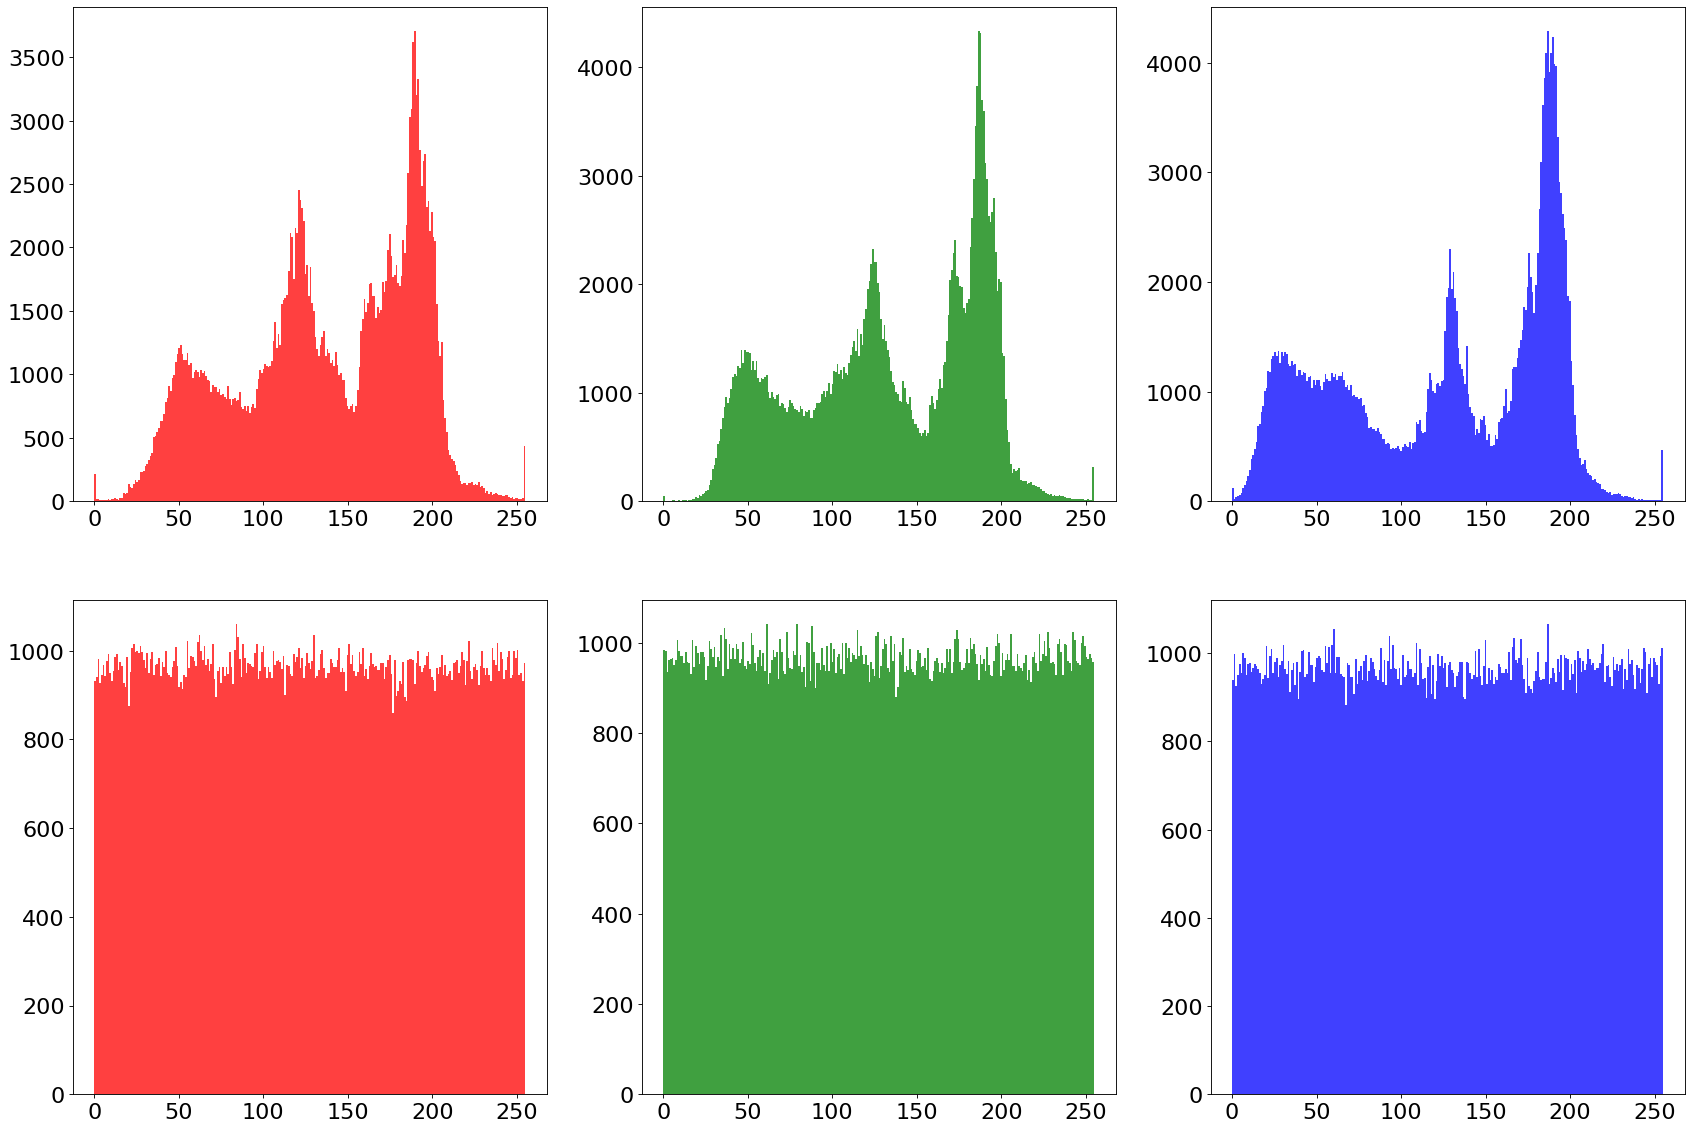

0

In [15]:
from PIL import Image
from matplotlib.widgets import Cursor
import numpy as np
import matplotlib.pyplot as plt
import math

def expectation(x,n):
    #print(x)
    tatal = 0.0
    for i in range(n):
        tatal = tatal + x[i]
    E = tatal/n
    #print(E)
    return E

def Variance(x,n):
    varValue = 0.0
    expValue = expectation(x,n)
    for i in range(n):
        varValue = varValue + math.pow(x[i]-expValue,2)
    return varValue/n

def cov(x,y,n):
    covValue = 0.0
    expX = expectation(x,n)
    expY = expectation(y,n)
    for i in range(n):
        covValue = covValue + (x[i] - expX)*(y[i]-expY)
    return covValue/n
def corr_coefficient(x,y,n):
    covValue = cov(x,y,n)
    varX = Variance(x,n)
    varY = Variance(y,n)
    varX = math.sqrt( varX )
    varY = math.sqrt( varY )
    #print(covValue,varX,varY)
    return  covValue/(varX*varX)

def Correlation(img,img2,LineColor,itype):
    x0=[]
    x1=[]
    y0=[]
    y1=[]
    if itype == 'Horizontal':
        for a in range(128):
            for b in range(32):
                if 2*a+1 < img.shape[0] and 4*b < img.shape[1]:
                    x0.append(img2[2*a][4*b])
                    x1.append(img2[1+2*a][4*b])
                    y0.append(img[2*a][4*b])
                    y1.append(img[1+2*a][4*b])
    elif itype == 'Vertical':
        for a in range(32):
            for b in range(128):
                if 4*a < img.shape[0] and 2*b+1 < img.shape[1]:
                    x0.append(img2[4*a][2*b])
                    x1.append(img2[4*a][1+2*b])
                    y0.append(img[4*a][2*b])
                    y1.append(img[4*a][1+2*b])
    else:
        for a in range(128):
            for b in range(32):
                if 2*a+1 < img.shape[0] and 4*b+1 < img.shape[1]:
                    x0.append(img2[2*a][4*b])
                    x1.append(img2[1+2*a][1+4*b])
                    y0.append(img[2*a][4*b])
                    y1.append(img[1+2*a][1+4*b])
    return x0,x1,y0,y1

def calc(img,itype):
    arrarR = img
    x,y = arrarR.shape
    # choose 5000 random position (row and col)
    np.random.seed(1111)
    positionX = np.random.randint(x-2,size=(5000, 1))
    positionY = np.random.randint(y-2,size=(5000, 1))
    position = np.hstack((positionX, positionY))
#     print(position)
    
    if itype == 'Horizontal':
        value1 = arrarR[position[0:,0],position[0:,1]] 
        value2 = arrarR[position[0:,0],position[0:,1]+1] 
    elif itype == 'Vertical':
        value1 = arrarR[position[0:,0],position[0:,1]] 
        value2 = arrarR[position[0:,0]+1,position[0:,1]] 
    else:
        value1 = arrarR[position[0:,0],position[0:,1]] 
        value2 = arrarR[position[0:,0]+1,position[0:,1]+1] 
    return corr_coefficient(value1,value2,5000)


def HistogramColorTest(to_file=None):
    icount = 0
    index = 0
    path = './test2/'
    pictures = os.listdir(path)
    for picName in pictures:
        index += 1
    index *=2
    plt.rcParams['axes.titlesize'] = 25
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    variances = []
    coors = []
    for picName in pictures:
        plt.figure(figsize=(26,9*index),dpi=80)
        picPath = path + picName
        lenna_img = np.array(Image.open(picPath))
        print(picName,"'s size is :", lenna_img.shape)    
#         plt.subplot(index,3,1+icount*3),plt.imshow(lenna_img,cmap="gray")
        plt.title(picName)
        
        time_start=time.time()
        lenna_cipher, keys = DoColorEnc(lenna_img,round=1)
        time_end=time.time()    
#         plt.subplot(index,3,2+icount*3),plt.imshow(lenna_cipher,cmap="gray")
        plt.title("Enc " + picName)
    
        # Original Histogram Variance
        
        arr=lenna_img[:,:,0].flatten()
        plt.subplot(index,3,1+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='red', alpha=0.75) 
        varValueR = Variance(arr,arr.size)    
        print("Red channel's variance is ",str(varValueR))
        
        arr=lenna_img[:,:,1].flatten() 
        plt.subplot(index,3,2+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='green', alpha=0.75) 
        varValueG = Variance(arr,arr.size)    
        print("Green channel's variance is ",str(varValueG))
        
        arr=lenna_img[:,:,2].flatten() 
        plt.subplot(index,3,3+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='blue', alpha=0.75) 
        varValueB = Variance(arr,arr.size)    
        print("Blue channel's variance is ",str(varValueB))
        
#         variances.append((picName, varValueR, varValueG, varValueB))
        
        #Histogram variance
        arr=lenna_cipher[:,:,0].flatten()
        plt.subplot(index,3,4+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='red', alpha=0.75) 
        varValueR = Variance(arr,arr.size)    
        print("Encrypted Red channel's variance is ",str(varValueR))
        
        arr=lenna_cipher[:,:,1].flatten() 
        plt.subplot(index,3,5+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='green', alpha=0.75) 
        varValueG = Variance(arr,arr.size)    
        print("Encrypted Green channel's variance is ",str(varValueG))
        
        arr=lenna_cipher[:,:,2].flatten() 
        plt.subplot(index,3,6+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='blue', alpha=0.75) 
        varValueB = Variance(arr,arr.size)    
        print("Encrypted Blue channel's variance is ",str(varValueB))

        
        #Encrypted Correlation
        corr = []
        print("Correlation")
        print("R channel: Horizontal             Vertical            Diagonal")
        x1R=calc(lenna_img[:,:,0],'Horizontal')
        x2R=calc(lenna_img[:,:,0],'Vertical')
        x3R=calc(lenna_img[:,:,0],'Diagonal')
        print(x1R,x2R,x3R)
        print("G channel: Horizontal             Vertical            Diagonal")
        x1G=calc(lenna_img[:,:,1],'Horizontal')
        x2G=calc(lenna_img[:,:,1],'Vertical')
        x3G=calc(lenna_img[:,:,1],'Diagonal')
        print(x1G,x2G,x3G)
        print("B channel: Horizontal             Vertical            Diagonal")
        x1B=calc(lenna_img[:,:,2],'Horizontal')
        x2B=calc(lenna_img[:,:,2],'Vertical')
        x3B=calc(lenna_img[:,:,2],'Diagonal')
        print(x1B,x2B,x3B)
        
        corr.extend([picName, x1R, x2R, x3R, x1G, x2G, x3G, x1B, x2B, x3B])
        
        #Encrypted Correlation
        print("Correlation")
        print("R channel: Horizontal             Vertical            Diagonal")
        x1R=calc(lenna_cipher[:,:,0],'Horizontal')
        x2R=calc(lenna_cipher[:,:,0],'Vertical')
        x3R=calc(lenna_cipher[:,:,0],'Diagonal')
        print(x1R,x2R,x3R)
        print("G channel: Horizontal             Vertical            Diagonal")
        x1G=calc(lenna_cipher[:,:,1],'Horizontal')
        x2G=calc(lenna_cipher[:,:,1],'Vertical')
        x3G=calc(lenna_cipher[:,:,1],'Diagonal')
        print(x1G,x2G,x3G)
        print("B channel: Horizontal             Vertical            Diagonal")
        x1B=calc(lenna_cipher[:,:,2],'Horizontal')
        x2B=calc(lenna_cipher[:,:,2],'Vertical')
        x3B=calc(lenna_cipher[:,:,2],'Diagonal')
        print(x1B,x2B,x3B)
        
        corr.extend([x1R, x2R, x3R, x1G, x2G, x3G, x1B, x2B, x3B])
        coors.append(corr)
        
#         time_DecStart=time.time()
#         lenna_dec = DoColorDec(lenna_cipher,keys, round=1)
#         time_DecEnd=time.time()
        
#         plt.subplot(index,3,3+icount*3),plt.imshow(lenna_dec,cmap="gray")
#         plt.title("Dec " + picName)
        plt.show()
    
#         print("Function Enc cost time:", time_end-time_start)
#         print("Function Dec cost time:", time_DecEnd-time_DecStart, end="\n\n")
        icount += 1   
    if to_file:
        variances = np.array(variances)
        coors = np.array(coors)
        
        vD = pd.DataFrame(variances, columns=["Image Name", "Red Channel", "Green Channel", "Blue Channel"])
        cD = pd.DataFrame(coors, columns=["Image Name", "Red Channel Horizontal", "Red Channel Vertical", "Red Channel Diagonal", "Green Channel Horizontal", "Green Channel Vertical", "Green Channel Diagonal", "Blue Channel Horizontal", "Blue Channel Vertical", "Blue Channel Diagonal", "Red Channel Horizontal", "Red Channel Vertical", "Encrypted Red Channel Diagonal", "Encrypted Green Channel Horizontal", "Encrypted Green Channel Vertical", "Encrypted Green Channel Diagonal", "Encrypted Blue Channel Horizontal", "Encrypted Blue Channel Vertical", "Encrypted Blue Channel Diagonal"])
        
        vD.to_csv("variance-" + to_file, index=False)
        cD.to_csv("correlation-" + to_file, index=False)
    return 0

HistogramColorTest()

520.png 's size is : (222, 66, 3)
Red channel's variance is  3455.059589646027
Green channel's variance is  4308.272149872025
Blue channel's variance is  4718.096292904279
Encrypted Red channel's variance is  5475.701336634637
Encrypted Green channel's variance is  5491.50148689374
Encrypted Blue channel's variance is  5489.473708179751


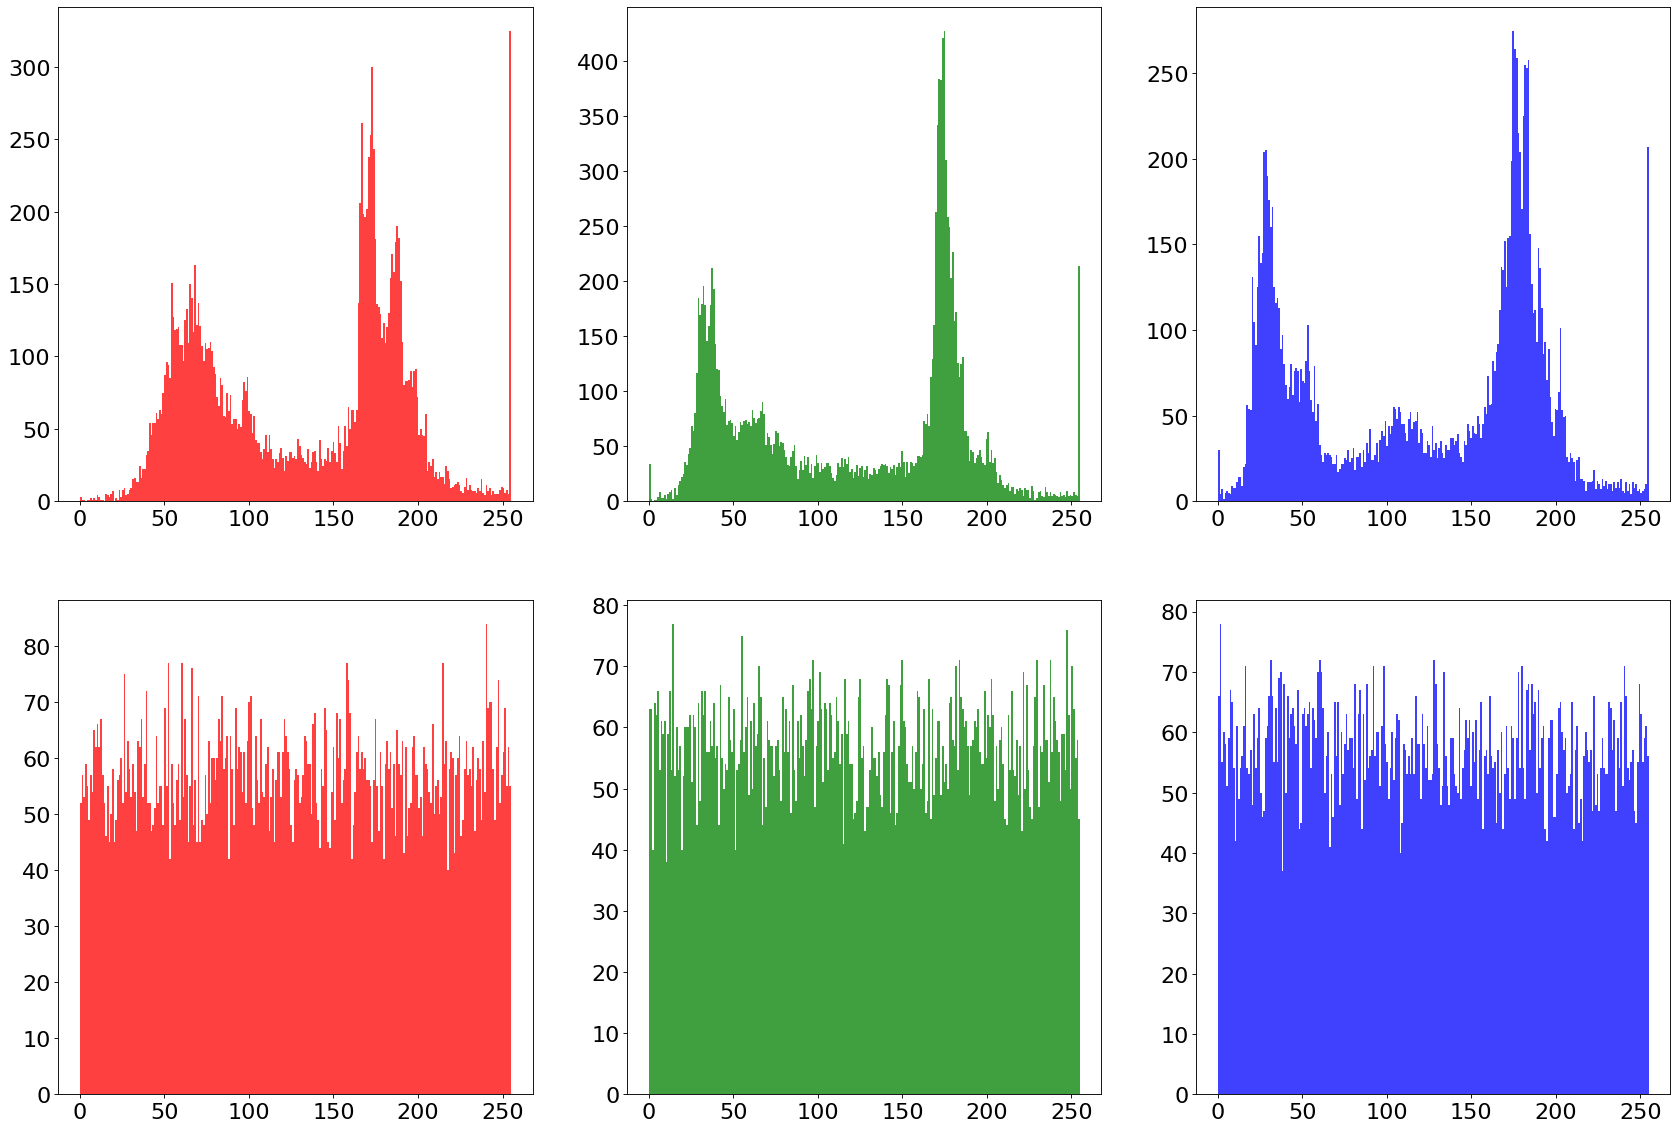

0

In [16]:
def HistogramCroppedColorTest(to_file=None):
    icount = 0
    index = 0
    path = './test2/'
    pictures = os.listdir(path)
    for picName in pictures:
        index += 1
    index *=2

    plt.figure(figsize=(26,9*index),dpi=80)
    plt.rcParams['axes.titlesize'] = 25
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    variances = []
    coors = []
    for picName in pictures:
        picPath = path + picName
#         lenna_img = np.array(Image.open(picPath))
        lenna_img, (x, y) = detect_object(picPath)
        print(picName,"'s size is :", lenna_img.shape)    
#         plt.subplot(index,3,1+icount*3),plt.imshow(lenna_img,cmap="gray")
        plt.title(picName)
        
        time_start=time.time()
        lenna_cipher, keys = DoColorEnc(lenna_img,round=1)
        time_end=time.time()    
#         plt.subplot(index,3,2+icount*3),plt.imshow(lenna_cipher,cmap="gray")
        plt.title("Enc " + picName)
    
        # Original Histogram Variance
        
        arr=lenna_img[:,:,0].flatten()
        plt.subplot(index,3,1+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='red', alpha=0.75) 
        varValueR = Variance(arr,arr.size)    
        print("Red channel's variance is ",str(varValueR))
        
        arr=lenna_img[:,:,1].flatten() 
        plt.subplot(index,3,2+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='green', alpha=0.75) 
        varValueG = Variance(arr,arr.size)    
        print("Green channel's variance is ",str(varValueG))
        
        arr=lenna_img[:,:,2].flatten() 
        plt.subplot(index,3,3+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='blue', alpha=0.75) 
        varValueB = Variance(arr,arr.size)    
        print("Blue channel's variance is ",str(varValueB))
        
#         variances.append((picName, varValueR, varValueG, varValueB))
        
        #Histogram variance
        arr=lenna_cipher[:,:,0].flatten()
        plt.subplot(index,3,4+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='red', alpha=0.75) 
        varValueR = Variance(arr,arr.size)    
        print("Encrypted Red channel's variance is ",str(varValueR))
        
        arr=lenna_cipher[:,:,1].flatten() 
        plt.subplot(index,3,5+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='green', alpha=0.75) 
        varValueG = Variance(arr,arr.size)    
        print("Encrypted Green channel's variance is ",str(varValueG))
        
        arr=lenna_cipher[:,:,2].flatten() 
        plt.subplot(index,3,6+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='blue', alpha=0.75) 
        varValueB = Variance(arr,arr.size)    
        print("Encrypted Blue channel's variance is ",str(varValueB))

        
#         #Correlation
#         print("Correlation")
#         print("R channel: Horizontal             Vertical            Diagonal")
#         x1R=calc(lenna_cipher[:,:,0],'Horizontal')
#         x2R=calc(lenna_cipher[:,:,0],'Vertical')
#         x3R=calc(lenna_cipher[:,:,0],'Diagonal')
#         print(x1R,x2R,x3R)
#         print("G channel: Horizontal             Vertical            Diagonal")
#         x1G=calc(lenna_cipher[:,:,1],'Horizontal')
#         x2G=calc(lenna_cipher[:,:,1],'Vertical')
#         x3G=calc(lenna_cipher[:,:,1],'Diagonal')
#         print(x1G,x2G,x3G)
#         print("B channel: Horizontal             Vertical            Diagonal")
#         x1B=calc(lenna_cipher[:,:,2],'Horizontal')
#         x2B=calc(lenna_cipher[:,:,2],'Vertical')
#         x3B=calc(lenna_cipher[:,:,2],'Diagonal')
#         print(x1B,x2B,x3B)
        
#         coors.append((picName, x1R, x2R, x3R, x1G, x2G, x3G, x1B, x2B, x3B))
        
#         time_DecStart=time.time()
#         lenna_dec = DoColorDec(lenna_cipher,keys, round=1)
#         time_DecEnd=time.time()
        
#         plt.subplot(index,3,3+icount*3),plt.imshow(lenna_dec,cmap="gray")
#         plt.title("Dec " + picName)
        plt.show()
    
#         print("Function Enc cost time:", time_end-time_start)
#         print("Function Dec cost time:", time_DecEnd-time_DecStart, end="\n\n")
        icount += 1   
    if to_file:
        variances = np.array(variances)
        coors = np.array(coors)
        
        vD = pd.DataFrame(variances, columns=["Image Name", "Red Channel", "Green Channel", "Blue Channel"])
        cD = pd.DataFrame(coors, columns=["Image Name", "Red Channel Horizontal", "Red Channel Vertical", "Red Channel Diagonal", "Green Channel Horizontal", "Green Channel Vertical", "Green Channel Diagonal", "Blue Channel Horizontal", "Blue Channel Vertical", "Blue Channel Diagonal"])
        
        vD.to_csv("variance-" + to_file, index=False)
        cD.to_csv("correlation-" + to_file, index=False)
    return 0

HistogramCroppedColorTest()